<a href="https://colab.research.google.com/github/HC-JEONG/IndustryAI/blob/master/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step1. 구글 드라이브에 분석할 데이터를 zip 형태로 넣어두기
>   fire data의 경우 구글 드라이브에 anydata라는 폴더를 만들고 label.zip 파일을 넣어두었음. label.zip 안에는 train/test로 나누어져 있음.


# Step2. Colab 켜기

# Step3. 왼쪽 상단에 런타임 > 런타임 유형 변경 > 하드웨어 가속기 GPU로 설정

>   개발 환경 확인

In [0]:
!cat /proc/cpuinfo
!nvidia-smi
!cat /etc/issue

*  Ubuntu 18.04
*  CUDA 10.1
*  Intel Xeon CPU @ 2.00GHz or 2.30GHz
*  Tesla P100 or Tesla K80

# Step4. 구글 드라이브를 Colab에 연동

>   아래 셀을 실행하면 링크가 하나 나온다.



1.   링크 클릭
2.   구글 계정 로그인
3.   'Google Drive File Stream이(가) 내 Google 계정에 액세스하려고 합니다.' 화면에서 허용 클릭
4.   코드 복사
5.   Enter your autorization code 란에 붙여 넣기 후 Enter



In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

> 위 셀 실행을 마치면 왼쪽 위 목차 옆 파일 탭에 gdrive -> My Drive 폴더가 생기고 이 폴더 안에 구글 드라이브 자료들이 동기화 되어있는 것을 확인할 수 있다.



>   아래 셀을 실행할 때 저장 경로나 파일명이 다른 부분이 있다면 바꿔준다.

# Step5. 구글 드라이브에 저장한 자료 압축 풀기

In [0]:
!unzip "/content/gdrive/My Drive/industryai/project/label.zip" -d images

>   /content/images에 test, train 폴더가 각각 생겨있고 안에 데이터가 들어있는 것을 확인 할 수 있다.

#Step6. Tensorflow model repository, COCO repository 복사, COCO object detection API 설치

In [0]:
!git clone https://github.com/tensorflow/models.git
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/models/research/



> 위 셀을 실행하면 /content에 cocoapi, models 폴더가 설치된걸 확인 할 수 있다. 구글드라이브에 models.zip, cocoapi.zip이 있으면 아래 두 셀을 실행하면 된다.



In [0]:
!unzip "/content/gdrive/My Drive/industryai/project/models.zip" -d models

In [0]:
!unzip "/content/gdrive/My Drive/industryai/project/cocoapi.zip" -d cocoapi

# Step7. 몇 가지 더 설치

In [0]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython

In [0]:
%cd /content/models/research/ 
# models 폴더가 다른 경로에 있으면 수정해준다
!protoc object_detection/protos/*.proto --python_out=.

>   위 셀에 다운로드하는 파일들을 미리 준비해 코드 실행을 생략하더라도 아래 셀은 실행해야 한다.

In [0]:
import os
os.environ['PYTHONPATH'] +=':/content/models/research/:/content/models/research/slim'

In [0]:
!python setup.py build
!python setup.py install

In [0]:
!python object_detection/builders/model_builder_test.py

# Step8. XML to CSV

In [0]:
%cd /content/models/research/

> 아래 셀을 실행하기 전에


1.   xml_to_csv.py 파일을 /content/models/research에 넣어준다.
2.   data 폴더를 /content/models/research에 만들어준다.
3.   /content에 있는 images 폴더를 /content/models/research 폴더에 넣어준다.
4.   아래 셀 실행



In [0]:
!python xml_to_csv.py

>   위 셀 실행 결과 content/models/research/data 폴더 안에 csv 파일이 생성되고 파일 실행했을 때 내용이 들어 있으면 정상적으로 변환 된 것이다.

# Step9. CSV to TFRecord

>   아래 셀을 실행하면 test.record, train.record가 /content/models/research 폴더에 생긴다.

**이미 파일이 있으면 test.record, train.record 파일을 /content/models/research에 넣어둔다**

In [0]:
# for test data
!python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=test.record  --image_dir=images/test
# for train data
!python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=train.record  --image_dir=images/train

# Step10. Tutorial 설치

In [0]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz

In [0]:
!tar -xvf ssd_mobilenet_v1_coco_11_06_2017.tar.gz

>   아래 셀을 실행하거나 ssd_mobilenet_v1_coco.config 파일을 content/models/research에 넣어준다.

In [0]:
!curl https://github.com/tensorflow/models/blob/master/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config

# Step11. NGROK 설치

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
LOG_DIR = 'training'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
# Install
! npm install -g localtunnel
! npm i -g npm
# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url1.txt 2>&1 &')
# Get url

In [0]:
! cat url1.txt

>   아래 셀을 실행하기 전에 해야할 것
train.py를 /content/models/research에 넣어둔다

1.   training폴더에 object-detection.pbtxt, ~coco.config 파일을 넣어둔다.
2.   research 폴더에 train.py, train.record, test.record, ~coco.config를 넣어둔다.
3.   data 폴더 안에 object-detection.pbtxt, test.record, train.record를 넣어둔다.



In [0]:
!python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/ssd_mobilenet_v1_coco.config

>   아래 셀을 실행하기 전에 export_inference_graph.py를 content/models/research에 넣어둔다

In [0]:
!python export_inference_graph.py \
--input_type image_tensor \
--pipeline_config_path training/ssd_mobilenet_v1_coco.config \
--trained_checkpoint_prefix training/model.ckpt-2000 \
--output_directory My_exp_graph/

In [0]:
!zip -r MY_exp_g.zip My_exp_graph

In [0]:
MODEL_NAME = 'My_exp_graph'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/object-detection.pbtxt'
NUM_CLASSES = 1

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/images/test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image_{}.jpg'.format(i)) for i in range(90, 93) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
os.getcwd()

In [0]:
!pip install utils

In [0]:
import utils

In [0]:
from object_detection.utils import label_map_util

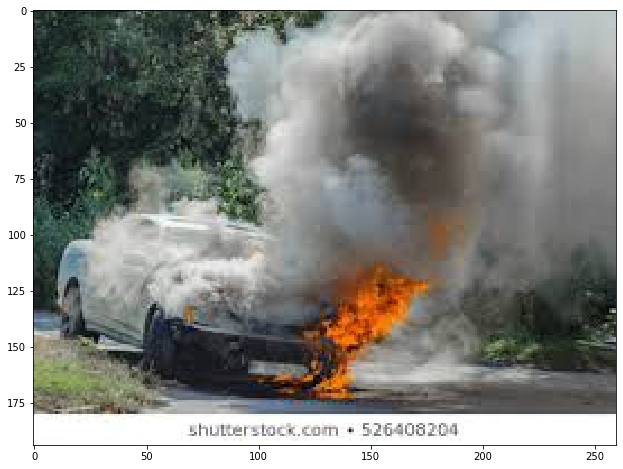

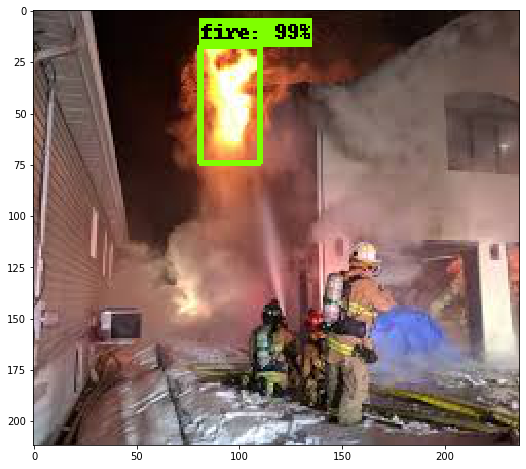

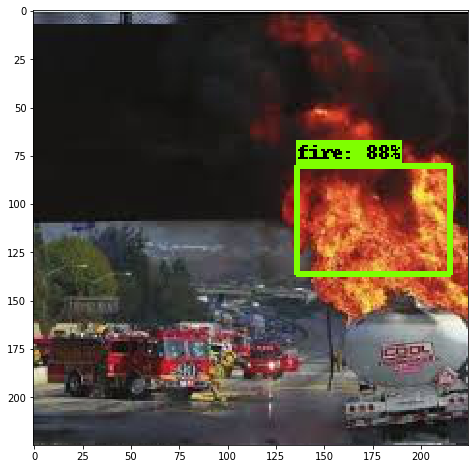

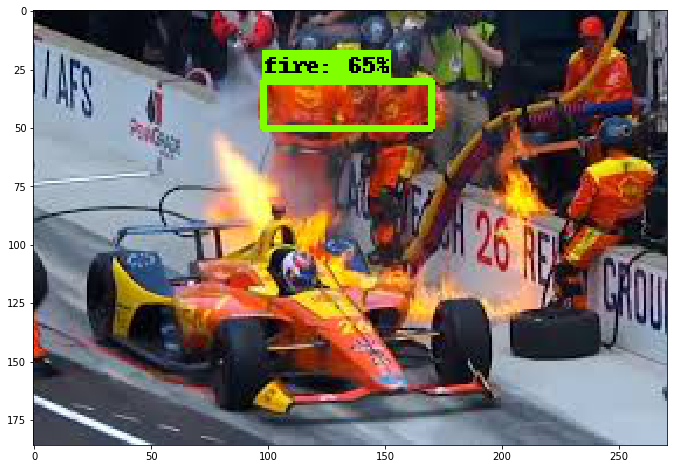

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
%matplotlib inline
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
# Loading label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
#Helper code
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
# Detection -------------------------------------------------------
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/models/research/images/test/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image_{}.jpg'.format(i)) for i in range(105,109) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (12,8)
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
# Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
# The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
# Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
# Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
# Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image})
# all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=3)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [0]:
#GPU 확인
import tensorflow as tf
device_name=tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [0]:
#남은 런타임 확인
import time, psutil
Start = time.time()- psutil.boot_time()
Left= 12*3600 - Start
print('Time remaining for this session is: ', Left/3600)

In [0]:
####Delete all flags before declare#####
def del_all_flags(FLAGS): 
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)